<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [3]:
csv_file = '../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'

import pandas as pd

df = pd.read_csv(csv_file)
print(df.shape)
df.head(8)

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."
5,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,ByPainter Marlow,"https://www.barcodable.com/upc/841710106442,ht..."
6,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,ive not 

In [4]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [5]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

def tokenize(text):
    round_1 = ' '.join(
        [token for token in simple_preprocess(text) if token not in STOPWORDS]
    )
    doc = nlp(round_1)
    tokens = [token.lemma_ for token in doc
              if not token.is_stop
              and not token.is_punct
              and not token.is_space
              and len(token.lemma_) > 2]
    return tokens

def doc_stream(texts):
    for text in texts:
        yield(tokenize(text))

In [7]:
from gensim import corpora

id2word = corpora.Dictionary(doc_stream(df['reviews.text']))

In [8]:
len(id2word.keys())

7561

In [9]:
id2word.filter_extremes(no_below=5, no_above=0.95)

In [10]:
len(id2word.keys())

2767

In [15]:
z = ''
for item in id2word.items():
    z = z + ', ' + item[1]
print(z)

, backup, bad, battery, item, miss, order, quality, spring, work, bulk, expensive, like, product, way, duracell, happy, price, brand, well, great, lasting, long, amazon, amazonbasics, arrive, basic, buy, cell, christmas, difference, easy, good, hand, haven, house, lot, notice, purchase, have, past, pleased, cheap, look, non, perfect, rechargeable, energizer, half, high, hold, juice, power, aaa, appear, life, shelf, will, basics, believe, equal, large, one, package, sooner, start, superior, bag, beat, feel, get, hard, inconsistent, last, longer, maybe, recent, test, easily, fish, guest, light, love, night, switch, tank, use, want, -PRON-, comment, day, delivery, job, keyboard, quick, year, need, thing, able, condition, exactly, shipping, thankful, know, camera, candle, cold, crazy, duracel, expose, lack, lead, near, north, opinion, sheet, size, trail, consider, control, december, gift, month, remote, replacement, toy, door, second, ship, controller, explode, review, say, xbox, disappoin

In [16]:
corpus = [id2word.doc2bow(text) for text in doc_stream(df['reviews.text'])]

In [35]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        print(f'Starting pass {iter_ + 1} of {passes}...')
        for num_topics in range(start, limit, step):
            if num_topics % 6 == 0:
                print(f'\t{num_topics} topics')
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [22]:
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=3, 
                                                        limit=22, 
                                                        step=3,
                                                        passes=5)

Starting pass 0...
	6 topics
	12 topics
	18 topics
Starting pass 1...
	6 topics
	12 topics
	18 topics
Starting pass 2...
	6 topics
	12 topics
	18 topics
Starting pass 3...
	6 topics
	12 topics
	18 topics
Starting pass 4...
	6 topics
	12 topics
	18 topics


In [23]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,3,-2.216135
1,0,6,-2.338680
2,0,9,-2.414334
3,0,12,-2.374283
4,0,15,-2.419413


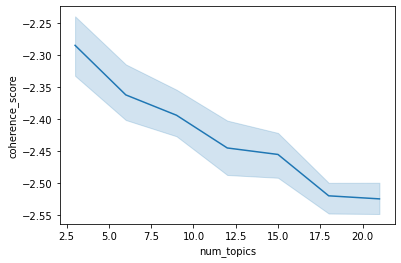

In [24]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## I think I filtered too many words out for this to corpus to be useful

I'm going to try again without the filtering.

I'm going to generate the lemmas and corpus once, because using the generator funciton this way takes way too long.

In [29]:
lemma_gen = doc_stream(df['reviews.text'])

In [30]:
df['lemmas'] = [lemma for lemma in lemma_gen]

In [33]:
id2word = corpora.Dictionary(df['lemmas'])

print('words in vocabulary: ', len(id2word.keys()))

df['corpus'] = [id2word.doc2bow(text) for text in df['lemmas']]

df.head()

words in vocabulary:  7561


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,lemmas,corpus
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, item, bad, quality, miss, backup, spri...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, product, like]","[(10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]"
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...","[duracell, price, happy]","[(15, 1), (16, 1), (17, 1)]"
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...","[work, brand, battery, well, price]","[(3, 1), (9, 1), (17, 1), (18, 1), (19, 1)]"
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...","[battery, long, lasting, price, great]","[(3, 1), (17, 1), (20, 1), (21, 1), (22, 1)]"


Starting pass 1 of 5...
	6 topics
	12 topics
	18 topics
	24 topics
	30 topics
Starting pass 2 of 5...
	6 topics
	12 topics
	18 topics
	24 topics
	30 topics
Starting pass 3 of 5...
	6 topics
	12 topics
	18 topics
	24 topics
	30 topics
Starting pass 4 of 5...
	6 topics
	12 topics
	18 topics
	24 topics
	30 topics
Starting pass 5 of 5...
	6 topics
	12 topics
	18 topics
	24 topics
	30 topics


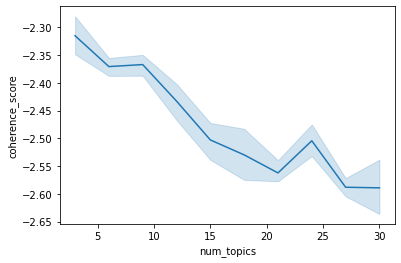

In [36]:
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=df['corpus'],
                                                        start=3, 
                                                        limit=31, 
                                                        step=3,
                                                        passes=5)

topic_coherence = pd.DataFrame.from_records(coherence_values)

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [37]:
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs',
       'lemmas', 'corpus'],
      dtype='object')

In [38]:
df['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64

In [39]:
lda_9topics = LdaMulticore(
    corpus=df['corpus'],
    num_topics=9,
    id2word=id2word,
    workers=4,
    random_state=42
)

lda_24topics = LdaMulticore(
    corpus=df['corpus'],
    num_topics=24,
    id2word=id2word,
    workers=4,
    random_state=42
)

In [41]:
dir(lda_9topics)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'alpha',
 'batch',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offset',
 'optimize_al

In [46]:
lda_9topics[df.loc[0, 'corpus']]

[(0, 0.010113891),
 (1, 0.010114524),
 (2, 0.010111665),
 (3, 0.010111877),
 (4, 0.9191012),
 (5, 0.010111194),
 (6, 0.010112259),
 (7, 0.010113063),
 (8, 0.010110311)]

In [65]:
import re

def get_distributions(lda, docs):
    num_topics = len(lda.get_topics())
    
    words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics(num_topics=-1, num_words=10)]
    topic_labels = [' '.join(t[0:8]) for t in words]
    
    print(num_topics, len(topic_labels))
    print(topic_labels)
    
    sparse_distro = [lda[doc] for doc in docs]
    
    def inflate(doc):
        d_dist = {f'topic_{k}':0 for k in range(num_topics)}
    
        for topic in doc:
            d_dist[f'topic_{topic[0]}'] = topic[1]
        
        return d_dist
    
    df_distro = pd.DataFrame.from_records([inflate(doc) for doc in sparse_distro])
    df_distro.columns = topic_labels
    
    return df_distro

In [61]:
df_9topics = get_distributions(lda_9topics, df['corpus'])

df_9topics['category'] = df['primaryCategories']
df_9topics['rating'] = df['reviews.rating']
df_9topics['num_helpful'] = df['reviews.numHelpful']

df_9topics.head()

9 9
['love great old tablet use year kindle battery', 'battery great kindle use buy price amazon work', 'love app screen battery kid easy work great', 'good buy tablet love amazon old year easy', 'great work battery love use good price tablet', 'great good battery price love use like ipad', 'good battery great amazon product app long screen', 'great battery tablet work buy price long good', 'tablet battery great kid brand good like buy']


,love great old tablet use year kindle battery,battery great kindle use buy price amazon work,love app screen battery kid easy work great,good buy tablet love amazon old year easy,great work battery love use good price tablet,great good battery price love use like ipad,good battery great amazon product app long screen,great battery tablet work buy price long good,tablet battery great kid brand good like buy,category,rating,num_helpful
0,0.010114,0.010115,0.010112,0.010112,0.919101,0.010111,0.010112,0.010113,0.010110,Health & Beauty,3,NaN
1,0.018530,0.507242,0.018533,0.018532,0.018533,0.018533,0.363024,0.018535,0.018539,Health & Beauty,4,NaN
2,0.027788,0.027797,0.385366,0.027787,0.027795,0.420075,0.027799,0.027800,0.027794,Health & Beauty,5,NaN
3,0.018523,0.018535,0.018527,0.018524,0.018529,0.018534,0.018528,0.851765,0.018535,Health & Beauty,5,NaN
4,0.018524,0.018529,0.018525,0.018522,0.018525,0.018531,0.018529,0.851791,0.018526,Health & Beauty,5,NaN


In [66]:
df_24topics = get_distributions(lda_24topics, df['corpus'])

df_24topics['category'] = df['primaryCategories']
df_24topics['rating'] = df['reviews.rating']
df_24topics['num_helpful'] = df['reviews.numHelpful']

df_24topics.head()

24 24
['kindle love great use old buy limit year', 'battery great use price buy amazon work brand', 'app love ipad kid great gift battery easy', 'buy good love tablet amazon old easy year', 'great read love price book battery good work', 'great price good battery love use kid case', 'good battery great product price long amazon feature', 'great battery price buy tablet long work quality', 'battery brand great price like good web buy', 'great love value kid enjoy buy child easy', 'great battery use buy price easy play watch', 'buy good great like love work amazon easy', 'tablet love use easy grandson game work nice', 'battery long year buy old love need amazon', 'love screen good work daughter buy great battery', 'tablet good battery kid price kindle use app', 'battery buy amazon great long product brand like', 'battery buy amazon old good love year screen', 'tablet great like use good watch buy battery', 'good battery product great old friendly game amazon', 'good tablet great book bat

,kindle love great use old buy limit year,battery great use price buy amazon work brand,app love ipad kid great gift battery easy,buy good love tablet amazon old easy year,great read love price book battery good work,great price good battery love use kid case,good battery great product price long amazon feature,great battery price buy tablet long work quality,battery brand great price like good web buy,great love value kid enjoy buy child easy,...,battery buy amazon old good love year screen,tablet great like use good watch buy battery,good battery product great old friendly game amazon,good tablet great book battery work love price,great use work price tablet easy good love,buy kindle great love gift purchase christmas use,love battery play great buy work daughter good,category,rating,num_helpful
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.422450,0.000000,0.000000,0.000000,0.000000,Health & Beauty,3,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.840271,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Health & Beauty,4,NaN
2,0.010417,0.010417,0.010417,0.010417,0.010417,0.760408,0.010417,0.010417,0.010417,0.010417,...,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,Health & Beauty,5,NaN
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.840276,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Health & Beauty,5,NaN
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.840273,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Health & Beauty,5,NaN


In [78]:
pt_9 = df_9topics.drop(columns=['rating', 'num_helpful']).pivot_table(index='category')
pt_9

,battery great kindle use buy price amazon work,good battery great amazon product app long screen,good buy tablet love amazon old year easy,great battery tablet work buy price long good,great good battery price love use like ipad,great work battery love use good price tablet,love app screen battery kid easy work great,love great old tablet use year kindle battery,tablet battery great kid brand good like buy
category,,,,,,,,,
Animals & Pet Supplies,0.142001,0.009256,0.168282,0.009258,0.182101,0.166650,0.009257,0.073029,0.215417
Electronics,0.079445,0.054578,0.230156,0.077871,0.091894,0.103267,0.106736,0.150585,0.088116
"Electronics,Furniture",0.320677,0.253278,0.000000,0.000000,0.154939,0.000000,0.000000,0.223828,0.000000
"Electronics,Media",0.163770,0.028685,0.120786,0.044049,0.141999,0.256576,0.071079,0.132774,0.022062
Health & Beauty,0.171138,0.112146,0.057753,0.213969,0.154373,0.082895,0.053095,0.052603,0.091920
Home & Garden,0.013949,0.013949,0.013951,0.013948,0.013948,0.013949,0.854125,0.013949,0.013949
Office Supplies,0.121250,0.164145,0.147479,0.140929,0.060907,0.216012,0.104283,0.022496,0.022498
"Office Supplies,Electronics",0.140089,0.053166,0.186669,0.080508,0.113024,0.157727,0.127954,0.099606,0.025139
"Toys & Games,Electronics",0.050266,0.045001,0.283706,0.046865,0.073176,0.078545,0.143459,0.158342,0.102400


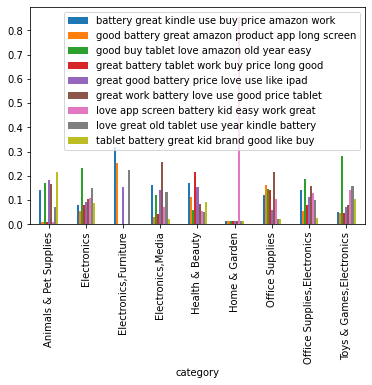

In [79]:
# 9 topics does not match up to 90 categories

pt_9.plot(kind='bar');

In [80]:
pt_9 = df_9topics.drop(columns=['category', 'num_helpful']).pivot_table(index='rating')
pt_9

,battery great kindle use buy price amazon work,good battery great amazon product app long screen,good buy tablet love amazon old year easy,great battery tablet work buy price long good,great good battery price love use like ipad,great work battery love use good price tablet,love app screen battery kid easy work great,love great old tablet use year kindle battery,tablet battery great kid brand good like buy
rating,,,,,,,,,
1,0.260773,0.136598,0.074518,0.096419,0.053466,0.172132,0.045541,0.050564,0.091116
2,0.239950,0.110798,0.093836,0.126905,0.091245,0.140742,0.046776,0.052429,0.079301
3,0.124793,0.106158,0.152512,0.147509,0.113946,0.116427,0.060738,0.066103,0.095063
4,0.093804,0.074176,0.190477,0.107254,0.109344,0.111408,0.082334,0.111369,0.103965
5,0.114042,0.074072,0.155851,0.142578,0.124703,0.083749,0.091940,0.114695,0.084991


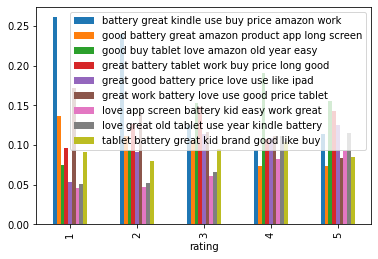

In [81]:
pt_9.plot(kind='bar');

In [82]:
pt_24 = df_24topics.drop(columns=['category', 'num_helpful']).pivot_table(index='rating')
pt_24

,app love ipad kid great gift battery easy,battery brand great price like good web buy,battery buy amazon great long product brand like,battery buy amazon old good love year screen,battery great use price buy amazon work brand,battery long year buy old love need amazon,buy good great like love work amazon easy,buy good love tablet amazon old easy year,buy kindle great love gift purchase christmas use,good battery great product price long amazon feature,...,great love value kid enjoy buy child easy,great price good battery love use kid case,great read love price book battery good work,great use work price tablet easy good love,kindle love great use old buy limit year,love battery play great buy work daughter good,love screen good work daughter buy great battery,tablet good battery kid price kindle use app,tablet great like use good watch buy battery,tablet love use easy grandson game work nice
rating,,,,,,,,,,,,,,,,,,,,,
1,0.010859,0.058171,0.136634,0.096911,0.044528,0.132011,0.005715,0.025192,0.024432,0.045027,...,0.004238,0.011805,0.047680,0.026496,0.019337,0.036624,0.016627,0.020386,0.029844,0.012186
2,0.020397,0.068739,0.076524,0.067198,0.064350,0.091708,0.019983,0.030676,0.019615,0.053292,...,0.012427,0.021632,0.071796,0.028774,0.032600,0.029538,0.022086,0.038315,0.033986,0.014831
3,0.034093,0.056039,0.053368,0.037605,0.039765,0.069882,0.022145,0.054748,0.030941,0.036951,...,0.026110,0.029741,0.039385,0.036680,0.014940,0.015669,0.039006,0.065361,0.048282,0.026238
4,0.034127,0.032180,0.023687,0.028189,0.028190,0.030447,0.021495,0.063297,0.043812,0.040866,...,0.046207,0.041648,0.031759,0.058157,0.033965,0.024479,0.032054,0.061076,0.060187,0.048082
5,0.029813,0.041557,0.034150,0.023843,0.032465,0.036151,0.025034,0.056016,0.044533,0.037474,...,0.059244,0.059107,0.024713,0.058793,0.040658,0.021090,0.037301,0.042756,0.032607,0.043796


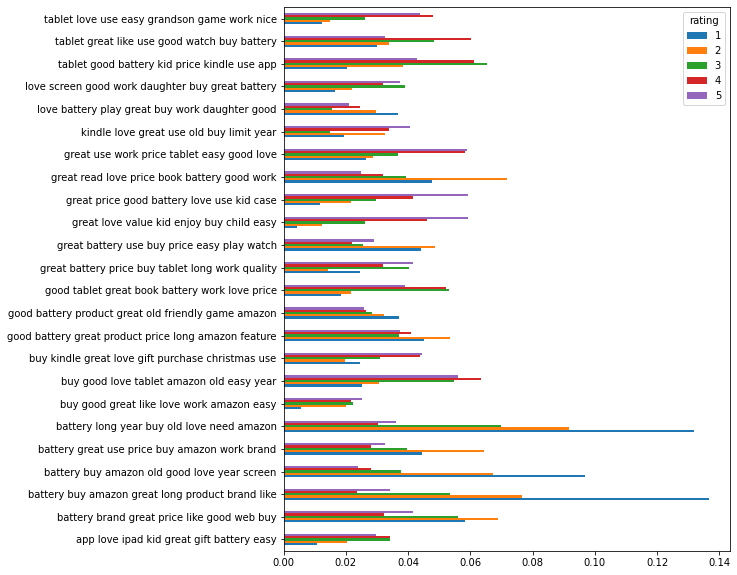

In [88]:
pt_24.T.plot(kind='barh', figsize=(8,10));

## Steps to Score New Documents

1. Tokenize Them (Same way you did training data)
2. Create the bag of words representations
3. Create the corpus object (Steps 2&3 pretty much same thing)
4. Loop of the new docs and score them using lda[doc]


## Steps to Score Training Documents
- Already have BOW Represented called 'corpus'

```
distro = [lda[d] for d in corpus]
num_topics = 5
def update(doc):
        d_dist = {k:0 for k in range(0,num_topics)}
        for topic in doc:
            # Topic is Tuple where the first part is the topic id
            # the second part is the topic distribution in that doc
            d_dist[topic[0]] = topic[1]
        return d_dist
new_distro = [update(d) for d in distro]
```

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling